# Part 1: The Evolution of Sequence Models

## From RNNs to Transformers

Before diving into code, let's understand **why** Transformers were invented. This context will make everything else click into place.

---

## The Problem: Sequence Modeling

Many real-world tasks involve sequences:
- **Language**: "The cat sat on the ___" → predict "mat"
- **Translation**: "Hello world" → "Bonjour monde"
- **Time series**: Stock prices, weather data
- **Music**: Note sequences

The challenge: **How do we process variable-length sequences while maintaining context?**


## Era 1: Recurrent Neural Networks (RNNs)

### The Idea
Process tokens one at a time, passing a "hidden state" from step to step.

```
Input:  [The] → [cat] → [sat] → [on] → [the] → [?]
          ↓        ↓       ↓       ↓       ↓
Hidden:  h1  →    h2  →   h3  →   h4  →   h5  → prediction
```

The hidden state `h` carries information about everything seen so far.


In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Simplified RNN cell
def rnn_cell(x, h_prev, W_xh, W_hh, W_hy, b_h, b_y):
    """
    One step of an RNN.
    
    x: current input (embedding)
    h_prev: previous hidden state
    
    Returns: new hidden state, output
    """
    # Combine input and previous hidden state
    h_new = np.tanh(x @ W_xh + h_prev @ W_hh + b_h)
    
    # Compute output
    y = h_new @ W_hy + b_y
    
    return h_new, y

# Demo: Process a sequence
np.random.seed(42)
hidden_size = 4
input_size = 3
output_size = 3

# Initialize weights
W_xh = np.random.randn(input_size, hidden_size) * 0.1
W_hh = np.random.randn(hidden_size, hidden_size) * 0.1
W_hy = np.random.randn(hidden_size, output_size) * 0.1
b_h = np.zeros(hidden_size)
b_y = np.zeros(output_size)

# Fake input sequence (5 tokens, each with 3-dim embedding)
sequence = np.random.randn(5, input_size)

# Process sequence
h = np.zeros(hidden_size)  # Initial hidden state
hidden_states = [h]

print("Processing sequence through RNN:")
print("=" * 40)
for i, x in enumerate(sequence):
    h, y = rnn_cell(x, h, W_xh, W_hh, W_hy, b_h, b_y)
    hidden_states.append(h)
    print(f"Step {i+1}: Input shape {x.shape} → Hidden shape {h.shape}")

print(f"\nFinal hidden state carries info from ALL {len(sequence)} tokens!")


Processing sequence through RNN:
Step 1: Input shape (3,) → Hidden shape (4,)
Step 2: Input shape (3,) → Hidden shape (4,)
Step 3: Input shape (3,) → Hidden shape (4,)
Step 4: Input shape (3,) → Hidden shape (4,)
Step 5: Input shape (3,) → Hidden shape (4,)

Final hidden state carries info from ALL 5 tokens!


### Problem 1: Sequential Bottleneck

RNNs **must** process tokens in order. This means:
- Can't parallelize training
- GPU utilization is poor
- Training is slow


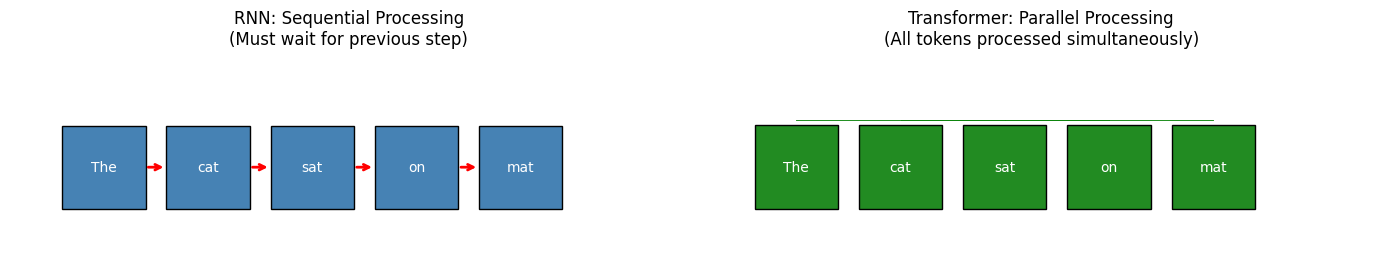

In [8]:
# Visualization: Sequential vs Parallel processing
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# RNN: Sequential
ax = axes[0]
tokens = ['The', 'cat', 'sat', 'on', 'mat']
for i, token in enumerate(tokens):
    ax.add_patch(plt.Rectangle((i, 0), 0.8, 0.8, facecolor='steelblue', edgecolor='black'))
    ax.text(i+0.4, 0.4, token, ha='center', va='center', fontsize=10, color='white')
    if i < len(tokens) - 1:
        ax.annotate('', xy=(i+1, 0.4), xytext=(i+0.8, 0.4),
                   arrowprops=dict(arrowstyle='->', color='red', lw=2))
ax.set_xlim(-0.5, 6)
ax.set_ylim(-0.5, 1.5)
ax.set_aspect('equal')
ax.axis('off')
ax.set_title('RNN: Sequential Processing\n(Must wait for previous step)', fontsize=12)

# Transformer: Parallel
ax = axes[1]
for i, token in enumerate(tokens):
    ax.add_patch(plt.Rectangle((i, 0), 0.8, 0.8, facecolor='forestgreen', edgecolor='black'))
    ax.text(i+0.4, 0.4, token, ha='center', va='center', fontsize=10, color='white')

# Draw connections between all tokens
for i in range(len(tokens)):
    for j in range(len(tokens)):
        if i != j:
            ax.plot([i+0.4, j+0.4], [0.85, 0.85], 'g-', alpha=0.3, lw=0.5)

ax.set_xlim(-0.5, 6)
ax.set_ylim(-0.5, 1.5)
ax.set_aspect('equal')
ax.axis('off')
ax.set_title('Transformer: Parallel Processing\n(All tokens processed simultaneously)', fontsize=12)

plt.tight_layout()
plt.show()


### Problem 2: Vanishing Gradients

During backpropagation, gradients must flow through **every step**. For long sequences, gradients get multiplied many times and either:
- **Vanish** (become tiny) → Early tokens are "forgotten"
- **Explode** (become huge) → Training becomes unstable


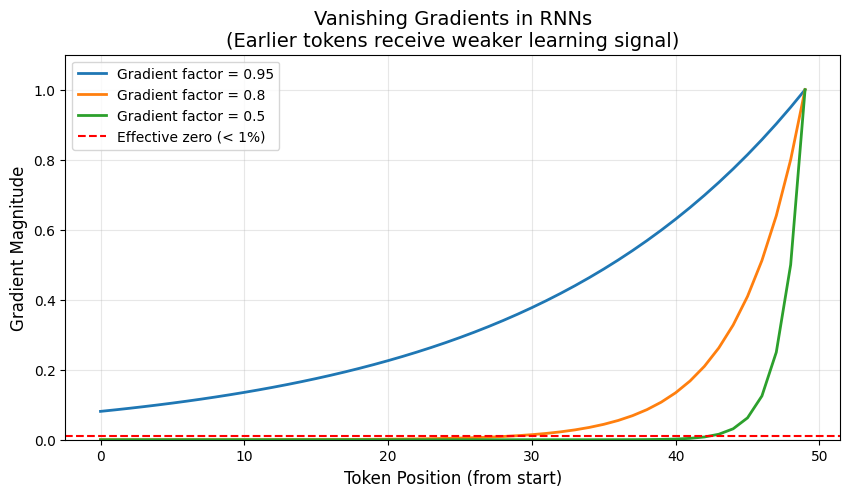

Notice: With gradient factor 0.8, after just 20 tokens,
the gradient is nearly zero. The model can't learn from early tokens!


In [9]:
# Demonstration: Gradient vanishing
def simulate_gradient_flow(sequence_length, gradient_factor=0.9):
    """Simulate how gradients diminish over sequence length."""
    gradients = []
    g = 1.0  # Start with gradient = 1
    
    for i in range(sequence_length):
        gradients.append(g)
        g *= gradient_factor  # Each step multiplies gradient
    
    return gradients[::-1]  # Reverse (backprop goes backward)

# Plot gradient flow for different sequence lengths
fig, ax = plt.subplots(figsize=(10, 5))

for factor in [0.95, 0.8, 0.5]:
    grads = simulate_gradient_flow(50, factor)
    ax.plot(grads, label=f'Gradient factor = {factor}', lw=2)

ax.axhline(y=0.01, color='red', linestyle='--', label='Effective zero (< 1%)')
ax.set_xlabel('Token Position (from start)', fontsize=12)
ax.set_ylabel('Gradient Magnitude', fontsize=12)
ax.set_title('Vanishing Gradients in RNNs\n(Earlier tokens receive weaker learning signal)', fontsize=14)
ax.legend()
ax.set_ylim(0, 1.1)
ax.grid(True, alpha=0.3)
plt.show()

print("Notice: With gradient factor 0.8, after just 20 tokens,")
print("the gradient is nearly zero. The model can't learn from early tokens!")


## Era 2: LSTMs and GRUs (1997-2014)

**Long Short-Term Memory (LSTM)** and **Gated Recurrent Units (GRU)** were designed to fix vanishing gradients.

### Key Innovation: Gates

LSTMs use "gates" to control information flow:
- **Forget gate**: What to forget from previous state
- **Input gate**: What new information to add
- **Output gate**: What to output

This creates "gradient highways" that allow information to flow over longer distances.

### LSTMs: Better, But Not Enough

| Aspect | RNN | LSTM | Transformer |
|--------|-----|------|-------------|
| Long-range memory | Poor | Good | Excellent |
| Training speed | Slow | Slow | Fast |
| Parallelization | No | No | Yes |
| Sequence length | ~100 | ~1000 | ~10000+ |


## Era 3: Attention Mechanism (2014)

### The Key Insight

Instead of compressing everything into a fixed-size hidden state, **let the model look directly at all previous tokens**.

The attention mechanism was first used in machine translation (Bahdanau et al., 2014):

```
Translating: "The black cat sat on the mat"

When generating "chat" (French for cat):
    → Focus strongly on "cat" in the input
    → Ignore "the", "on", "mat" mostly
```


In [10]:
def simple_attention(query, keys, values):
    """
    Simple attention mechanism.
    
    query: what we're looking for (d,)
    keys: what each position contains (seq_len, d)
    values: information at each position (seq_len, d)
    
    Returns: weighted sum of values based on query-key similarity
    """
    # Compute similarity between query and each key
    scores = keys @ query  # (seq_len,)
    
    # Convert to probabilities (softmax)
    weights = np.exp(scores) / np.sum(np.exp(scores))
    
    # Weighted sum of values
    output = weights @ values  # (d,)
    
    return output, weights

# Example: translating "The black cat" to French
# When generating "noir" (black), we want to focus on "black"

np.random.seed(42)
d = 4  # embedding dimension

# Fake embeddings for English words
words = ['The', 'black', 'cat']
embeddings = np.random.randn(3, d)

# Query: looking for color-related info (pretend this represents "noir")
query = embeddings[1] + np.random.randn(d) * 0.1  # Similar to "black"

output, weights = simple_attention(query, embeddings, embeddings)

print("Attention weights when generating 'noir' (black in French):")
print("=" * 50)
for word, weight in zip(words, weights):
    bar = '█' * int(weight * 30)
    print(f"{word:8} [{bar:30}] {weight:.2%}")

print("\nThe model 'attends' most to 'black' - exactly what we want!")


Attention weights when generating 'noir' (black in French):
The      [████████                      ] 27.19%
black    [█████████████████████         ] 71.54%
cat      [                              ] 1.27%

The model 'attends' most to 'black' - exactly what we want!


## Era 4: The Transformer (2017)

### "Attention Is All You Need"

The breakthrough paper by Vaswani et al. asked: **What if we remove recurrence entirely?**

Instead of:
```
Attention + RNN → Good but slow
```

They proposed:
```
Attention only → Fast AND good!
```

### Key Innovations

1. **Self-Attention**: Every token attends to every other token
2. **Multi-Head Attention**: Multiple attention "perspectives"
3. **Positional Encoding**: Inject position info (since no recurrence)
4. **Layer Normalization**: Stabilize training


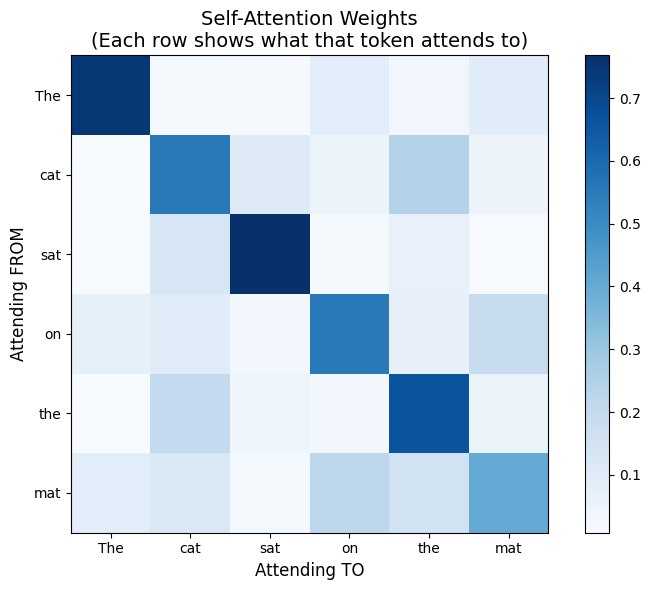

Each token can now 'see' all other tokens directly!
No sequential processing needed.


In [11]:
def self_attention(X):
    """
    Self-attention: each token attends to all tokens (including itself).
    
    X: input sequence (seq_len, d)
    Returns: attended sequence (seq_len, d), attention weights
    """
    seq_len, d = X.shape
    
    # Compute attention scores between all pairs
    scores = X @ X.T  # (seq_len, seq_len)
    
    # Scale by sqrt(d) for stability
    scores = scores / np.sqrt(d)
    
    # Softmax to get weights (each row sums to 1)
    exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True))  # Numerical stability
    weights = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    
    # Output: weighted sum for each position
    output = weights @ X  # (seq_len, d)
    
    return output, weights

# Example with a sentence
np.random.seed(42)
sentence = ['The', 'cat', 'sat', 'on', 'the', 'mat']
X = np.random.randn(len(sentence), 8)  # Random embeddings

output, attention_weights = self_attention(X)

# Visualize attention
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(attention_weights, cmap='Blues')
ax.set_xticks(range(len(sentence)))
ax.set_yticks(range(len(sentence)))
ax.set_xticklabels(sentence)
ax.set_yticklabels(sentence)
ax.set_xlabel('Attending TO', fontsize=12)
ax.set_ylabel('Attending FROM', fontsize=12)
ax.set_title('Self-Attention Weights\n(Each row shows what that token attends to)', fontsize=14)
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

print("Each token can now 'see' all other tokens directly!")
print("No sequential processing needed.")


## Why Transformers Won

### 1. Parallelization
All tokens processed simultaneously → **10-100x faster training**

### 2. Long-Range Dependencies
Direct connection between any two tokens → **No information bottleneck**

### 3. Scalability
Simple architecture scales to billions of parameters → **GPT, BERT, etc.**


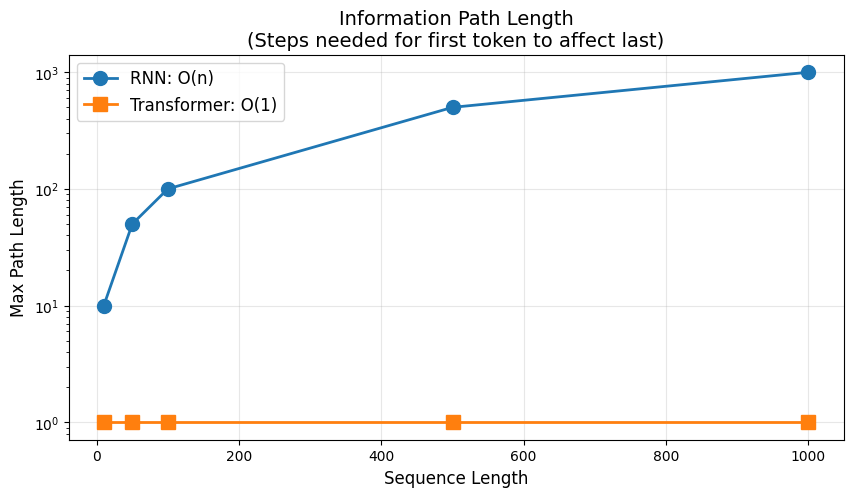

In a 1000-token sequence:
  RNN: Information travels through 1000 steps
  Transformer: Information travels through 1 step

This is why Transformers handle long documents so well!


In [12]:
# Comparison: Path length for information flow
def path_length_rnn(seq_len):
    """In RNN, info from token 0 to token n must pass through n steps."""
    return seq_len

def path_length_transformer(seq_len):
    """In Transformer, any token connects to any other in 1 step."""
    return 1

seq_lengths = [10, 50, 100, 500, 1000]

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(seq_lengths, [path_length_rnn(s) for s in seq_lengths], 
        'o-', label='RNN: O(n)', markersize=10, lw=2)
ax.plot(seq_lengths, [path_length_transformer(s) for s in seq_lengths], 
        's-', label='Transformer: O(1)', markersize=10, lw=2)

ax.set_xlabel('Sequence Length', fontsize=12)
ax.set_ylabel('Max Path Length', fontsize=12)
ax.set_title('Information Path Length\n(Steps needed for first token to affect last)', fontsize=14)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
ax.set_yscale('log')
plt.show()

print("In a 1000-token sequence:")
print(f"  RNN: Information travels through {path_length_rnn(1000)} steps")
print(f"  Transformer: Information travels through {path_length_transformer(1000)} step")
print("\nThis is why Transformers handle long documents so well!")


## Timeline Summary

```
1986: RNNs introduced
  └── Problem: Vanishing gradients, slow
  
1997: LSTM invented
  └── Better memory, still slow
  
2014: Attention mechanism (with RNN)
  └── Much better quality, still sequential
  
2017: Transformer ("Attention Is All You Need")
  └── Fast, parallel, scalable
  
2018: BERT (Transformer for understanding)
2018: GPT (Transformer for generation)
2020: GPT-3 (175B parameters)
2022: ChatGPT (GPT-3.5 with RLHF)
2023: GPT-4
```

---

## What's Next?

Now that you understand **why** Transformers exist, we'll build one from scratch!

In the next notebooks:
1. **02_embeddings.ipynb**: Convert text to numbers
2. **03_attention.ipynb**: Implement self-attention from scratch
3. **04_multihead_attention.ipynb**: Multiple attention heads
4. **05_transformer_block.ipynb**: Put it all together
5. **06_full_transformer.ipynb**: Complete architecture
6. **07_text_generation.ipynb**: Train and generate text!

---

### Key Takeaways

1. **RNNs** process sequences step-by-step → slow, forgetful
2. **LSTMs** improve memory → still slow
3. **Attention** lets models focus on relevant parts → quality boost
4. **Transformers** use ONLY attention → fast AND good
5. **Self-attention** is the core innovation → every token sees every other token
